### Implementation of Bengio et al 2013

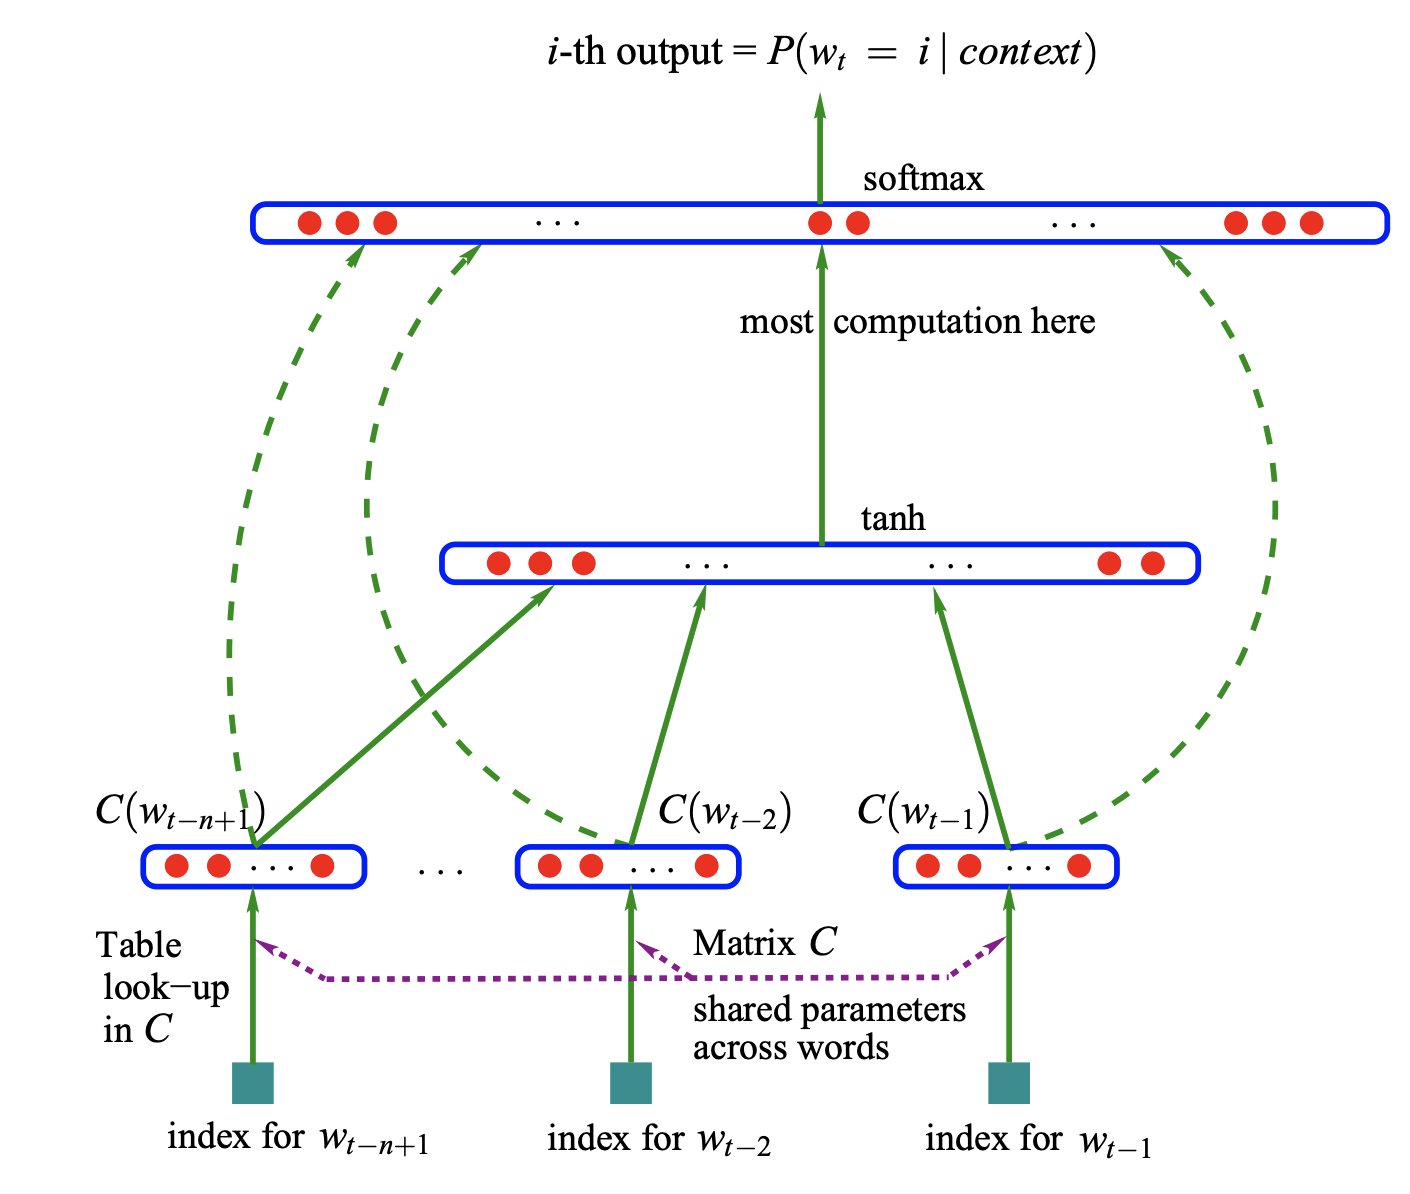

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

Vocab of chars and mapping to integers

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
block_size = 3 #context length
X, Y = [], []

for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)     

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [13]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([32, 3]), torch.Size([32]), torch.int64, torch.int64)

Embedding lookup table

- Create 2 dimensional embeddings

In [14]:
C = torch.randn([27, 2])

Picking out 5th row

In [18]:
C[5]

tensor([-0.8602, -1.6399])

Picking out 5th row with one hot and matmul

In [17]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.8602, -1.6399])

Index with a tensor

- Embedding for each 32,3 context vector

In [21]:
C[X].shape

torch.Size([32, 3, 2])

In [22]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Hidden Layer

In [24]:
W1 = torch.randn([3*2, 100]) #3 inputs of 2 dim and 100 neurons, 100 is a hyperparam
b1 = torch.randn(100)

Concat the embeddings

In [25]:
emb[:, 0, :].shape

torch.Size([32, 2])

In [27]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [28]:
a = torch.arange(18)

In [30]:
a.view(2, 3, 3) #extremely efficient, no new memory is created

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])

In [34]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # -1 infers the dim size and view concats 32,3,2 to 32,6
# same 100 dim bias vector is added

In [35]:
h.shape

torch.Size([32, 100])

Last layer - Softmax

In [36]:
W2 = torch.randn([100, 27])
b2 = torch.randn(27)

In [38]:
logits = h @ W2 + b2

In [39]:
logits.shape

torch.Size([32, 27])

In [40]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([32, 27])

In [41]:
probs[0].sum()

tensor(1.)

Prob of correct char

In [42]:
probs[torch.arange(32), Y]

tensor([4.5954e-01, 1.5110e-07, 3.7821e-12, 1.5683e-10, 5.9010e-09, 6.7880e-05,
        1.2303e-06, 1.0642e-05, 7.6312e-10, 9.7865e-06, 2.5599e-05, 1.2694e-09,
        5.1315e-08, 3.0703e-11, 3.4364e-06, 8.9699e-05, 5.2786e-14, 2.8798e-03,
        6.7810e-17, 4.4885e-10, 4.1789e-09, 2.8943e-08, 3.0500e-07, 1.0151e-12,
        5.1656e-10, 1.4137e-08, 8.7497e-05, 8.3323e-09, 1.1765e-06, 1.6364e-07,
        9.6648e-09, 2.1812e-11])

Loss

In [44]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.4868)

Combine all layers

Dataset

In [45]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

Parameters

In [47]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) #Embeddings
W1 = torch.randn((6, 100), generator=g) #Hidden layer
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)#Softmax layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
sum(p.nelement() for p in parameters) # total no of params

3481

Layers

Forward pass

In [56]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y) # much better impl in pytorch, avoid issue with large values, memeory efficient
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

Backward pass

In [57]:
for p in parameters:
    p.requires_grad=True

In [58]:
for p in parameters:
    p.grad = None
loss.backward()

#update
for p in parameters:
    p.data += -0.1 * p.grad

Full training loop

In [62]:
for _ in range(500):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.25577861070632935


Full dataset

In [66]:

block_size = 3 #context length
X, Y = [], []

for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)     

In [67]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [68]:
for _ in range(50):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

5.377645969390869
